In [11]:
import zipfile
with zipfile.ZipFile('brain_tumor_dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_dataset')

In [12]:
import os
import numpy as np
import ssl
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2, VGG19
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import shutil
from keras.optimizers import Adam
from keras.models import Sequential, load_model
# create train and test folders 
os.makedirs('train_dir', exist_ok = True)
os.makedirs('test_dir', exist_ok = True)

# create sub directories within the train and test folders for the yes and no tumor images
# iterates through no directory and then the yes directory
for subdir in os.listdir('brain_tumor_dataset/brain_tumor_dataset'):
    subdir_path = os.path.join('brain_tumor_dataset/brain_tumor_dataset', subdir)
    train_subdir = os.path.join('train_dir', subdir)
    test_subdir = os.path.join('test_dir', subdir)
    os.makedirs(train_subdir, exist_ok = True)
    os.makedirs(test_subdir, exist_ok = True)

    images = []
    
    # add all yes/no images to a list
    for image in os.listdir(subdir_path):
        images.append(image)
    
    # shuffle the images
    random.shuffle(images)
    # split the images into train/test (20%/80%)
    test_count = int(len(images) * .2)
    
    for i, image in enumerate(images):
        source_path = os.path.join(subdir_path, image) # get the original image path
        if i < test_count:
            dest_path = os.path.join(test_subdir, image) # first 20% of images get added to the test directory
        else:
            dest_path = os.path.join(train_subdir, image) # the rest get added to the train directory
        shutil.copy(source_path, dest_path)
    

In [13]:
# Augment the training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,  # Normalize pixel values
    rotation_range = 30,  # Randomly rotate images
    width_shift_range = 0.1,  # Randomly shift images horizontally
    height_shift_range = 0.1,  # Randomly shift images vertically
    shear_range = 0.1,  # Apply random shear transformations
    zoom_range = 0.1,  # Randomly zoom images
    horizontal_flip = True,  # Randomly flip images horizontally
    brightness_range = (.5, 1.0),
    fill_mode = 'nearest'  # Fill in newly created pixels after transformations
)

# Don't augment the test set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255.
)

train_gen = train_datagen.flow_from_directory(
    'train_dir',
    target_size = (244, 244),
    batch_size = 10,
    class_mode = 'binary',
    color_mode = 'rgb'
)

test_gen = test_datagen.flow_from_directory(
    'test_dir',
    target_size = (244, 244),
    batch_size = 10,
    class_mode = 'binary',
    color_mode = 'rgb'
)



Found 254 images belonging to 2 classes.
Found 193 images belonging to 2 classes.


In [14]:
# train the ResNet50V2 model
resnet_model = ResNet50V2(input_shape=(244,244,3), include_top=False) # setting include top = false allows us to add custom layers
resnet_model.trainable = False

model = Sequential([
    resnet_model,
    GlobalAveragePooling2D(),
    Flatten(),
    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet50v2_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history_resnet = model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=callbacks_list)

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.8349 - accuracy: 0.6496
Epoch 1: accuracy improved from -inf to 0.64961, saving model to resnet50v2_best.h5
26/26 [==============================] - 23s 822ms/step - loss: 0.8349 - accuracy: 0.6496 - val_loss: 0.4579 - val_accuracy: 0.7772
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.3153 - accuracy: 0.8858
Epoch 2: accuracy improved from 0.64961 to 0.88583, saving model to resnet50v2_best.h5
26/26 [==============================] - 20s 784ms/step - loss: 0.3153 - accuracy: 0.8858 - val_loss: 0.2233 - val_accuracy: 0.9119
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8583
Epoch 3: accuracy did not improve from 0.88583
26/26 [==============================] - 20s 778ms/step - loss: 0.2988 - accuracy: 0.8583 - val_loss: 0.1920 - val_accuracy: 0.9275
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.2303 - accuracy: 0.9331
Epoch 4: a

In [15]:
# train the VGG19 model
vgg_model = VGG19(input_shape = (224,224,3), include_top=False, weights='imagenet') # want the model to be trained on the ImageNet dataset
vgg_model.trainable = False

vgg_model = Sequential([
    Flatten(),
    Dropout(.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=['accuracy'])

checkpoint = tf.keras.callbacks.ModelCheckpoint('VGG19_best.h5', 
                                                monitor='accuracy', verbose=1, 
                                                mode='max',save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="accuracy", mode="max", restore_best_weights=True, patience=5)
callbacks_list = [checkpoint,early]

history_vgg = model.fit(train_gen, validation_data=test_gen, epochs=10, callbacks=callbacks_list)


    

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.3311 - accuracy: 0.8701
Epoch 1: accuracy improved from -inf to 0.87008, saving model to VGG19_best.h5
26/26 [==============================] - 24s 842ms/step - loss: 0.3311 - accuracy: 0.8701 - val_loss: 0.1015 - val_accuracy: 0.9689
Epoch 2/10
26/26 [==============================] - ETA: 0s - loss: 0.1938 - accuracy: 0.9252
Epoch 2: accuracy improved from 0.87008 to 0.92520, saving model to VGG19_best.h5
26/26 [==============================] - 21s 804ms/step - loss: 0.1938 - accuracy: 0.9252 - val_loss: 0.0923 - val_accuracy: 0.9689
Epoch 3/10
26/26 [==============================] - ETA: 0s - loss: 0.1677 - accuracy: 0.9252
Epoch 3: accuracy did not improve from 0.92520
26/26 [==============================] - 20s 779ms/step - loss: 0.1677 - accuracy: 0.9252 - val_loss: 0.0863 - val_accuracy: 0.9637
Epoch 4/10
26/26 [==============================] - ETA: 0s - loss: 0.1390 - accuracy: 0.9409
Epoch 4: accuracy im

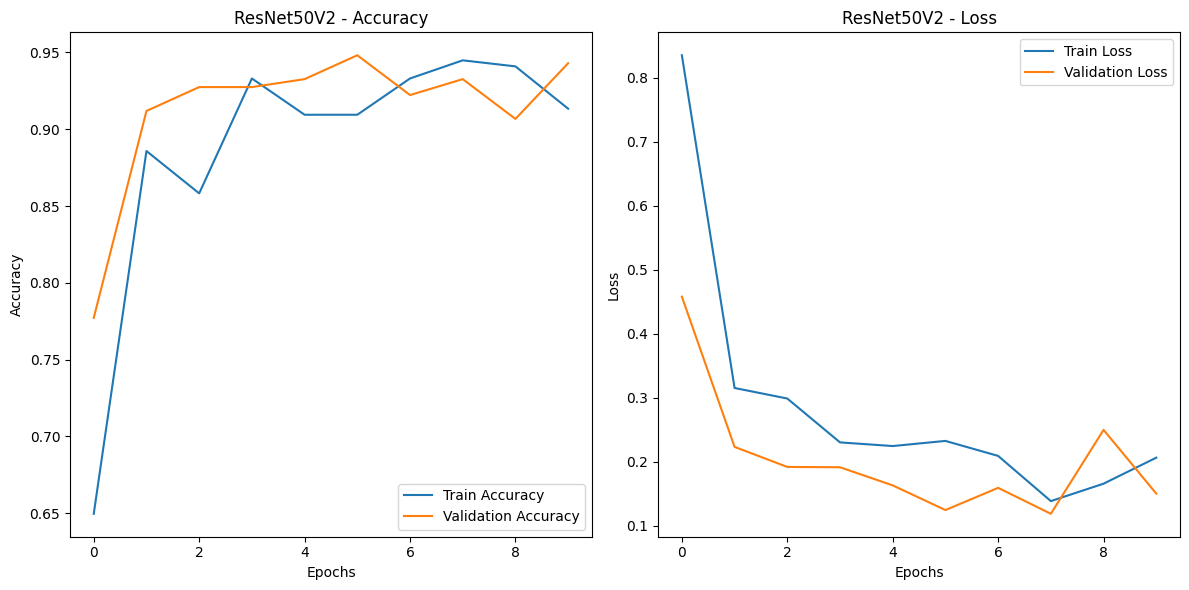

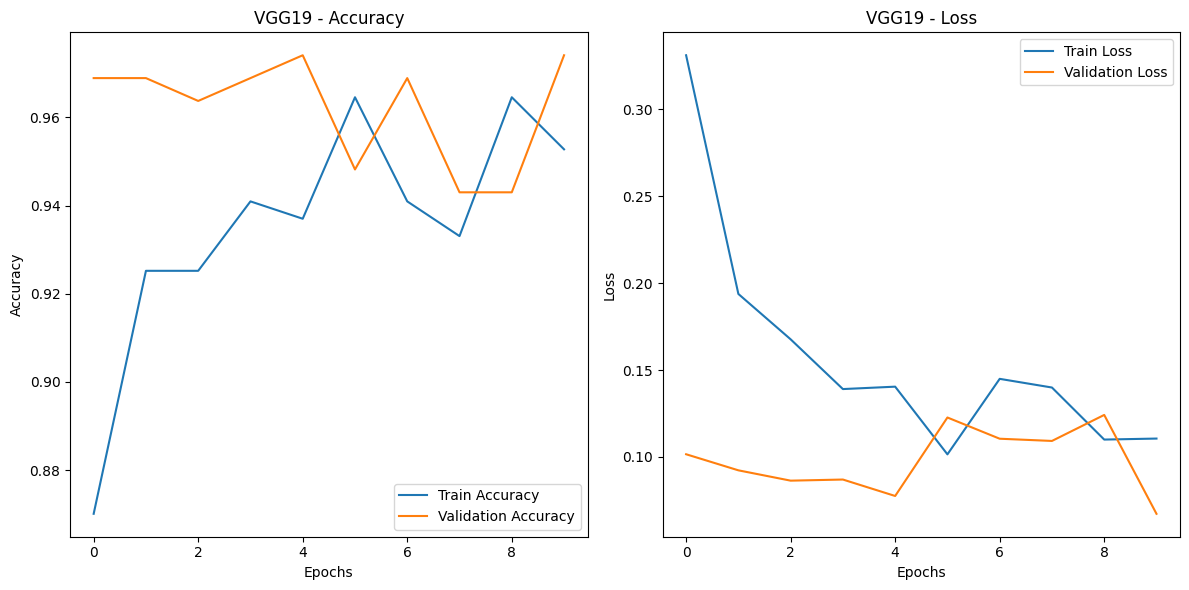

In [16]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    # Retrieve training history
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(12, 6))
    
    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracy, label='Train Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot the history
plot_history(history_resnet, title="ResNet50V2")
plot_history(history_vgg, title="VGG19")
